<a href="https://colab.research.google.com/github/Mondardo/DCGAN/blob/main/DCGAN_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Deep learning performance: K80 < P4 < T4 < P100
gpu = !nvidia-smi -L
print('Not using GPU' if 'failed' in gpu[0] else gpu[0].split(' (')[0])

GPU 0: Tesla P100-PCIE-16GB


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Reshape,
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image 
import os

from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

import time
from IPython import display # A command shell for interactive computing in Python.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = '/content/gdrive/My Drive/Colab Notebooks/cat/'

In [ ]:
img_size = 128

train_images = []

images = os.listdir(path)

for i in images: # all train cat images
    if os.path.isfile(path + i): # check image in file
        image = Image.open(path + i)
        image = image.resize((img_size,img_size), Image.ANTIALIAS) # resizing
        image = np.asarray(image) # bit format
        # only images with 3 dimensions and 3 channels:
        if (image.ndim == 3) and (image.shape[2] == 3):
          train_images.append(image)

np.shape(train_images)
train_images = np.array(train_images)

train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [ ]:
train_images, test_images = train_test_split(train_images, test_size=0.1)
print(f'Train set shape: {train_images.shape}')
print(f'Test set shape:  {test_images.shape}')

Train set shape: (4645, 128, 128, 3)
Test set shape:  (517, 128, 128, 3)


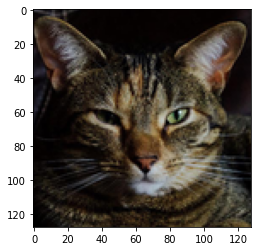

In [ ]:
plt.imshow(train_images[10]*0.5 + 0.5)

Frechet Inception Distance (FID):

In [ ]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, test_images):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(test_images)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

Generator net:

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(32*32*256, use_bias=False, input_shape=(300,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((32, 32, 256)))
    assert model.output_shape == (None, 32, 32, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) # transposed convolutional layer
    assert model.output_shape == (None, 32, 32, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

Discriminator net:

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 3])) #2D convolutional layer
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1)) #uma saída apenas, pois é para saber se é ou não é imagem real.

    return model

Discriminator and generator losses:

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) #compare the discriminator predictions on real images to an array of ones.
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) #compare the discriminator predictions on generated images to an array of zeros.
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) #compare the discriminator decisions on the generated images to a array of ones.

Training step:

In [ ]:
@tf.function
def train_step(images):
  
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # gera as imagens com o generator

      real_output = discriminator(images, training=True) # discriminator diz se as imagens reais são reais ou falsas
      fake_output = discriminator(generated_images, training=True) # discriminator diz se as imagens geradas são reais ou falsas

      gen_loss = generator_loss(fake_output) # computar a perda do generator
      disc_loss = discriminator_loss(real_output, fake_output) # computar a perda do discriminator

    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

Generate images, save those images and compute FID score:

In [ ]:
def generate_and_save_images(model, epoch, test_input, images1, test_images, fids):
  predictions = model(test_input, training=False)
  # Plot the generated images:
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
      plt.axis('off')
  # Save the generated images:
  #plt.savefig('/content/gdrive/My Drive/Colab Notebooks/GAN_gatos_24_03/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

  if (epoch+1) % 5 == 0:
    images1 = model(images1, training=False).numpy()
    shuffle(images1)
    ## convert to floating point values:
    images1 = images1.astype('float32')
    images2 = test_images.astype('float32')
    # resize images:
    images1 = scale_images(images1, (299,299,3))
    images2 = scale_images(images2, (299,299,3))
    ## pre-process images:
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)
    #calculate fid:
    fid = calculate_fid(model_inceptionV3, images1, images2)
    fids.append(fid)
  return fids

In [ ]:
# prepare the inception v3 model
model_inceptionV3 = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

In [ ]:
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 128

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

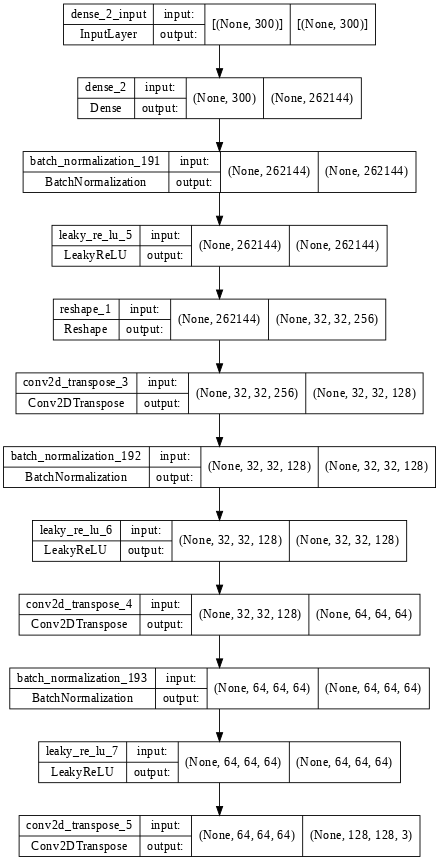

In [ ]:
generator = make_generator_model()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

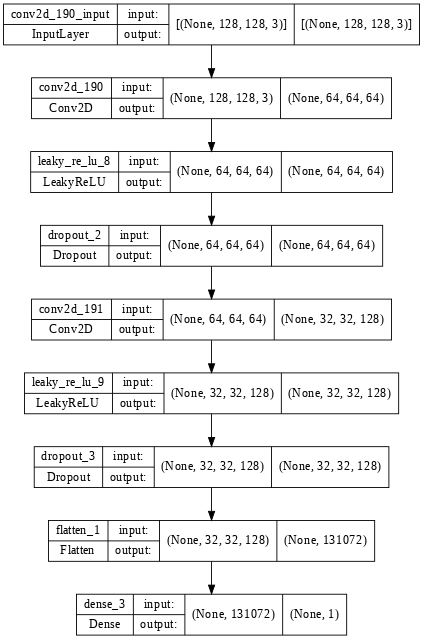

In [ ]:
discriminator = make_discriminator_model()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [ ]:
#Set checkpoins. Save progress.
ckpt_dir = '/content/gdrive/My Drive/Colab Notebooks/GAN_gatos_24_03_ckpt'
ckpt_prefix = os.path.join(ckpt_dir, "ckpt")
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 500
num_examples_to_generate = 16 # examples for visualization
num_examples_to_generate2 = test_images.shape[0] # examples to compute FID score
noise_dim = 300
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed2 = tf.random.normal([num_examples_to_generate2, noise_dim])

Training:

In [ ]:
def train(dataset, epochs, test_images):
  i = 0
  gen_losses = []
  disc_losses = []
  fids = []  
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      gloss, dloss = train_step(image_batch)
      gen_losses.append(gloss)
      disc_losses.append(dloss)

    display.clear_output(wait=True)
    fids = generate_and_save_images(generator, epoch + 1, seed, seed2, test_images, fids)

    # Save the model every 100 epochs as a checkpoint
    if (epoch + 1) % 100 == 0:
      ckpt.save(file_prefix = ckpt_prefix)

    # Print out the completed epoch no. and the time spent
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  return gen_losses, disc_losses, fids

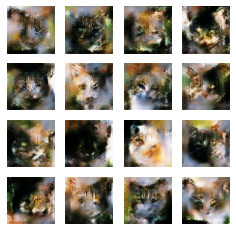

Time for epoch 500 is 13.400988340377808 sec


In [ ]:
gen_losses, disc_losses, fids = train(train_dataset, EPOCHS, train_images)

In [ ]:
gen_losses_new = []
for i in gen_losses:
  gen_losses_new.append(i.numpy())

disc_losses_new = []
for i in disc_losses:
  disc_losses_new.append(i.numpy())

# save losses and fid:
np.savetxt("/content/gdrive/My Drive/Colab Notebooks/GAN_gatos_24_03/gen_losses.csv", gen_losses_new)
np.savetxt("/content/gdrive/My Drive/Colab Notebooks/GAN_gatos_24_03/disc_losses.csv", disc_losses_new)
np.savetxt("/content/gdrive/My Drive/Colab Notebooks/GAN_gatos_24_03/fids.csv", fids)

Text(0, 0.5, 'Generator loss')

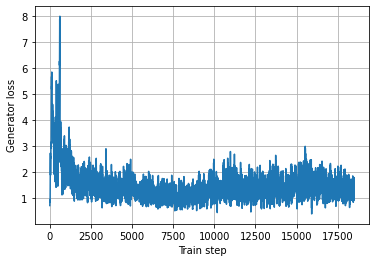

In [ ]:
plt.plot(gen_losses_new)
plt.grid()
plt.xlabel('Train step')
plt.ylabel('Generator loss')

Text(0, 0.5, 'Discriminator loss')

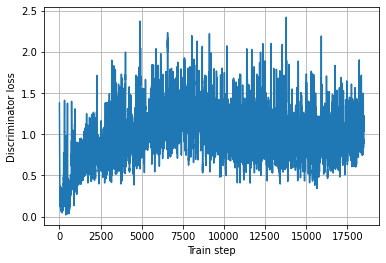

In [ ]:
plt.plot(disc_losses_new)
plt.grid()
plt.xlabel('Train step')
plt.ylabel('Discriminator loss')